In [13]:
import numpy as np                                        #导入numpy库并简写为np

# 生成布洛赫球面点数据集
n_samples = 150 #样本数量
x = np.random.rand(n_samples,2).astype(np.float32)
for i in range(x.shape[0]):
    x[i,0] = x[i,0]*np.pi
    x[i,1] = x[i,1]*np.pi*2
x_feature_names = ["theta","phi"]
y_target_names = ["below","above"]
y =np.ndarray((n_samples,)).astype(int)
for i in range(x.shape[0]):
    if x[i,0] >= np.pi/2:
        y[i] = 1
    else:
        y[i] = 0
print(x.shape)                                            #打印样本的数据维度
print(x_feature_names)                                    #打印样本的特征名称
print(y_target_names)                                     #打印样本包含的亚属名称
print(y)                                                  #打印样本的标签的数组
print(y.shape)                                            #打印样本的标签的数据维度

(150, 2)
['theta', 'phi']
['below', 'above']
[0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 1 0 0 1 0 0 0 0 1 1 0 1 0 1 1 1 0
 0 1 1 1 1 0 0 1 0 0 0 1 0 0 1 1 0 1 0 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 0 0 0
 1 0 1 0 0 1 0 1 0 0 1 0 1 1 1 0 1 1 0 0 1 0 1 1 0 1 1 1 0 1 1 0 0 0 0 1 0
 0 0 1 1 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0 1 1 1 1 0 0 1 1 0 0 1 1 0 1 1 1 1 0
 0 1]
(150,)


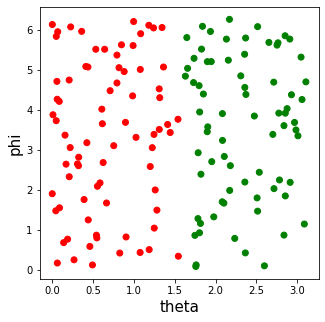

In [14]:
# 数据图像化

import matplotlib.pyplot as plt  

blochplt = plt.figure(figsize=(5, 5)).subplots()
colormap = {0: 'r', 1: 'g'}            #将标签为0的样本设为红色，标签为1的样本设为绿色
cvalue = [colormap[i] for i in y]      #将 n_samples 个样本对应的标签设置相应的颜色
blochplt.scatter(x[:,0],x[:,1],c = cvalue)
blochplt.set_xlabel("theta", fontsize = 15)
blochplt.set_ylabel("phi", fontsize = 15)
plt.show()

In [15]:
# 数据预处理

alpha = x[:,1]*x[:,0]         #每一个样本中，利用相邻两个特征值计算出一个参数
x = np.append(x,np.transpose((x[:,1]*x[:,0])[np.newaxis]),axis=1)
print(x.shape)                        #打印此时x的样本的数据维度

(150, 3)


In [16]:
#导入train_test_split函数，用于对数据集进行划分
from sklearn.model_selection import train_test_split
#将数据集划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, shuffle=True)
print(X_train.shape)                                      #打印训练集中样本的数据类型
print(X_test.shape)                                       #打印测试集中样本的数据类型

(120, 3)
(30, 3)


In [17]:
import mindquantum as mq                             #导入mindquantum库并简写为mq
from mindquantum.core import Circuit                      #导入Circuit模块，用于搭建量子线路
from mindquantum.core import UN                   #导入UN模块
from mindquantum.core import H, X, RZ                #导入量子门H, X, RZ

encoder = Circuit()                                  #初始化量子线路

encoder += UN(H, 2)                                  #H门作用在每1位量子比特    
for i in range(2):                                   #i = 0, 1      
    encoder += RZ(f'alpha{i}').on(i)                 #RZ(alpha_i)门作用在第i位量子比特
for j in range(1):                                   #j = 0
    encoder += X.on(j, j+1)                          #X门作用在第j+1位量子比特，受第j位量子比特控制
    encoder += RZ(f'alpha{j+2}').on(j+1)             #RZ(alpha_{j+2})门作用在第0位量子比特  
    encoder += X.on(j+1, j)                          #X门作用在第j+1位量子比特，受第j位量子比特控制
# 两个CNOT门对称放置效果还行
    
encoder = encoder.no_grad()                          #Encoder作为整个量子神经网络的第一层，不用对编码线路中的梯度求导数，因此加入no_grad()
encoder.summary()                                    #总结Encoder
encoder

==================Circuit Summary==================
|Total number of gates  : 7.                      |
|Parameter gates        : 3.                      |
|with 3 parameters are  : alpha0, alpha1, alpha2. |
|Number qubit of circuit: 2                       |


q0: ──H────RZ(alpha0)────X──────────────────●──
                         │                  │
q1: ──H────RZ(alpha1)────●────RZ(alpha2)────X──

In [18]:
from mindquantum.algorithm import HardwareEfficientAnsatz                                           
# 导入HardwareEfficientAnsatz
from mindquantum.core import RY                                                                     
# 导入量子门RY
ansatz = HardwareEfficientAnsatz(2, single_rot_gate_seq=[RY], entangle_gate=X, depth=3).circuit    
# 通过HardwareEfficientAnsatz搭建Ansatz !3层，效果未知!
ansatz.summary()                                                                                    
# 总结Ansatz
ansatz

==========================================Circuit Summary==========================================
|Total number of gates  : 11.                                                                     |
|Parameter gates        : 8.                                                                      |
|with 8 parameters are  : d0_n0_0, d0_n1_0, d1_n0_0, d1_n1_0, d2_n0_0, d2_n1_0, d3_n0_0, d3_n1_0. |
|Number qubit of circuit: 2                                                                       |


q0: ──RY(d0_n0_0)────●────RY(d1_n0_0)────●────RY(d2_n0_0)────●────RY(d3_n0_0)──
                     │                   │                   │
q1: ──RY(d0_n1_0)────X────RY(d1_n1_0)────X────RY(d2_n1_0)────X────RY(d3_n1_0)──

In [19]:
circuit = encoder + ansatz                   #完整的量子线路由Encoder和Ansatz组成
circuit.summary()
circuit

==================================================Circuit Summary==================================================
|Total number of gates  : 18.                                                                                     |
|Parameter gates        : 11.                                                                                     |
|with 11 parameters are : alpha0, alpha1, alpha2, d0_n0_0, d0_n1_0, d1_n0_0, d1_n1_0, d2_n0_0, d2_n1_0, d3_n0_0...|
|Number qubit of circuit: 2                                                                                       |


q0: ──H────RZ(alpha0)────X──────────────────●────RY(d0_n0_0)────●────RY(d1_n0_0)────●────RY(d2_n0_0)────●────RY(d3_n0_0)──
                         │                  │                   │                   │                   │
q1: ──H────RZ(alpha1)────●────RZ(alpha2)────X────RY(d0_n1_0)────X────RY(d1_n1_0)────X────RY(d2_n1_0)────X────RY(d3_n1_0)──

In [20]:
from mindquantum.core import QubitOperator                     # 导入QubitOperator模块，用于构造泡利算符
from mindquantum.core import Hamiltonian                       # 导入Hamiltonian模块，用于构建哈密顿量

hams = [Hamiltonian(QubitOperator(f'Z{i}')) for i in [0, 1]]   # 分别对第2位和第3位量子比特执行泡利Z算符测量，且将系数都设为1，构建对应的哈密顿量
print(hams)

[1.0 [Z0] , 1.0 [Z1] ]


In [21]:
import mindspore as ms                                                                         # 导入mindspore库并简写为ms
from mindquantum.framework import MQLayer                                                      # 导入MQLayer
from mindquantum.simulator import Simulator

ms.context.set_context(mode=ms.context.PYNATIVE_MODE, device_target="CPU")
ms.set_seed(1)                                                                                 # 设置生成随机数的种子
sim = Simulator('projectq', circuit.n_qubits)
grad_ops = sim.get_expectation_with_grad(hams,
                                         circuit,
                                         None,
                                         encoder.params_name,
                                         ansatz.params_name,
                                         parallel_worker=5)
QuantumNet = MQLayer(grad_ops)          # 搭建量子神经网络
QuantumNet

MQLayer<
  (evolution): MQOps<2 qubits projectq VQA Operator>
  >

In [22]:
from mindspore.nn import SoftmaxCrossEntropyWithLogits                         #导入SoftmaxCrossEntropyWithLogits模块，用于定义损失函数
from mindspore.nn import Adam, Accuracy                                        #导入Adam模块和Accuracy模块，分别用于定义优化参数，评估预测准确率
from mindspore import Model                                                    #导入Model模块，用于建立模型
from mindspore.dataset import NumpySlicesDataset                               #导入NumpySlicesDataset模块，用于创建模型可以识别的数据集
from mindspore.train.callback import Callback, LossMonitor                     #导入Callback模块和LossMonitor模块，分别用于定义回调函数和监控损失

loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')            #通过SoftmaxCrossEntropyWithLogits定义损失函数，sparse=True表示指定标签使用稀疏格式，reduction='mean'表示损失函数的降维方法为求平均值
opti = Adam(QuantumNet.trainable_params(), learning_rate=0.005)                  #通过Adam优化器优化Ansatz中的参数，需要优化的是Quantumnet中可训练的参数，学习率设为0.005   
        
model = Model(QuantumNet, loss, opti, metrics={'Acc': Accuracy()})             #建立模型：将MindQuantum构建的量子机器学习层和MindSpore的算子组合，构成一张更大的机器学习网络
        
train_loader = NumpySlicesDataset({'features': X_train, 'labels': y_train}, shuffle=False).batch(5) #通过NumpySlicesDataset创建训练样本的数据集，shuffle=False表示不打乱数据，batch(5)表示训练集每批次样本点有5个
test_loader = NumpySlicesDataset({'features': X_test, 'labels': y_test}).batch(5)                   #通过NumpySlicesDataset创建测试样本的数据集，batch(5)表示测试集每批次样本点有5个

class StepAcc(Callback):                                                        #定义一个关于每一步准确率的回调函数
    def __init__(self, model, test_loader):
        self.model = model
        self.test_loader = test_loader
        self.acc = []

    def step_end(self, run_context):
        self.acc.append(self.model.eval(self.test_loader, dataset_sink_mode=False)['Acc'])  

monitor = LossMonitor(16)                                                       #监控训练中的损失，每16步打印一次损失值

acc = StepAcc(model, test_loader)                                               #使用建立的模型和测试样本计算预测的准确率

model.train(20, train_loader, callbacks=[monitor, acc], dataset_sink_mode=False)#将上述建立好的模型训练20次

epoch: 1 step: 16, loss is 0.6383525
epoch: 2 step: 8, loss is 0.57204795
epoch: 2 step: 24, loss is 0.61300075
epoch: 3 step: 16, loss is 0.51871073
epoch: 4 step: 8, loss is 0.44539708
epoch: 4 step: 24, loss is 0.5556626
epoch: 5 step: 16, loss is 0.4581325
epoch: 6 step: 8, loss is 0.38665974
epoch: 6 step: 24, loss is 0.5253094
epoch: 7 step: 16, loss is 0.4332965
epoch: 8 step: 8, loss is 0.36379132
epoch: 8 step: 24, loss is 0.5102919
epoch: 9 step: 16, loss is 0.42464575
epoch: 10 step: 8, loss is 0.3567571
epoch: 10 step: 24, loss is 0.5032114
epoch: 11 step: 16, loss is 0.42227393
epoch: 12 step: 8, loss is 0.35563713
epoch: 12 step: 24, loss is 0.49992314
epoch: 13 step: 16, loss is 0.42189556
epoch: 14 step: 8, loss is 0.35619694
epoch: 14 step: 24, loss is 0.49833846
epoch: 15 step: 16, loss is 0.42196554
epoch: 16 step: 8, loss is 0.35697123
epoch: 16 step: 24, loss is 0.49751425
epoch: 17 step: 16, loss is 0.42205915
epoch: 18 step: 8, loss is 0.3576
epoch: 18 step: 24, 

In [23]:
from mindspore import ops, Tensor                                            #导入ops模块和Tensor模块

predict = np.argmax(ops.Softmax()(model.predict(Tensor(X_test))), axis=1)    #使用建立的模型和测试样本，得到测试样本预测的分类
correct = model.eval(test_loader, dataset_sink_mode=False)                   #计算测试样本应用训练好的模型的预测准确率

print("预测分类结果：", predict)                                              #对于测试样本，打印预测分类结果
print("实际分类结果：", y_test)                                               #对于测试样本，打印实际分类结果

print(correct)                                                               #打印模型预测的准确率

预测分类结果： [1 1 1 0 0 1 1 1 1 0 0 1 0 1 1 0 0 1 0 1 1 1 0 0 0 0 1 1 0 0]
实际分类结果： [1 1 1 0 0 1 1 1 1 0 0 1 0 1 1 0 0 1 0 1 1 1 0 0 0 0 1 1 0 0]
{'Acc': 1.0}


Text(0, 0.5, 'Accuracy')

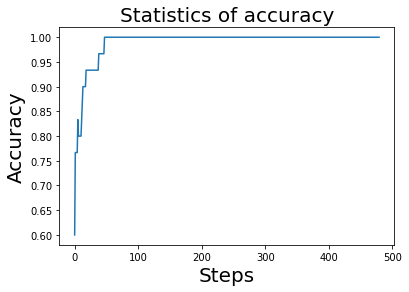

In [24]:
plt.plot(acc.acc)
plt.title('Statistics of accuracy', fontsize=20)
plt.xlabel('Steps', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)